# Yelp Case Study

### Case Study using `yelp_reviews`

> Practice problems from real companies, data and questions' source [Stratascratch](https://education.stratascratch.com)

In [1]:
# load packadges
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import string
import watermark
import psycopg2 as ps

from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

In [2]:
# print packadges information

%reload_ext watermark
%watermark -n -v -iv

pandas    0.25.3
watermark 2.0.2
psycopg2  2.8.4 (dt dec pq3 ext lo64)
numpy     1.18.1
Fri Apr 03 2020 

CPython 3.7.5
IPython 7.13.0


### Get familiar with data

In [3]:
yelp = pd.read_csv('./data/yelp_reviews.csv')

### Data Cleaning

In [4]:
yelp.head()

,business_name,review_id,user_id,stars,review_date,review_text,funny,useful,cool
0,Thai Pan Fresh Exotic Cuisine,0ESSqLfOae77muWTv_zUqA,r-t7IiTSD0QZdt8lOUCqeQ,3,2011-02-11,Lately i have been feeling homesick for asian ...,1,1,1
1,Salon Lola,VyAKIaj_Rmsf_ZCHcGJyUw,SS85hfTApRnbTPcJadra8A,5,2010-05-30,I love Marilo! She understands my hair type a...,0,0,0
2,Chipotle Mexican Grill,DusrkpkTGPGkqK13xO1TZg,xAVu2pZ6nIvkdHh8vGs84Q,3,2011-11-26,Standard Chipotle fare - consistently good; no...,0,0,0
3,Sam's Deli,A5FL-YYXnr2hnvXQbgkkrQ,Xuvj2Fq6c3mCmplVG7h21w,4,2013-10-10,Very good prices with quality ingredients.,0,0,0
4,Petco,SzhIWfzLHUZfiAaVTtKHxw,jHH_UDpCnF-YTnveyoMTIA,1,2012-09-02,I went to this Petco a few times and was a bit...,0,1,0


In [5]:
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16390 entries, 0 to 16389
Data columns (total 9 columns):
business_name    16390 non-null object
review_id        16390 non-null object
user_id          16390 non-null object
stars            16390 non-null object
review_date      16390 non-null object
review_text      16390 non-null object
funny            16390 non-null int64
useful           16390 non-null int64
cool             16390 non-null int64
dtypes: int64(3), object(6)
memory usage: 1.1+ MB


In [6]:
# convert review_date to datetime 
yelp['review_date']=yelp['review_date'].apply(pd.to_datetime)

In [7]:
# Checking the review_date column for oddities. 
# Yelp was made in 2004

# earliest review
yelp['review_date'].min()

Timestamp('2005-04-14 00:00:00')

In [8]:
# latest review
yelp['review_date'].max()

Timestamp('2014-01-28 00:00:00')

In [9]:
# duplicated entries
yelp.duplicated().sum(axis=0)

0

In [10]:
# incorrect values in 'stars'
yelp['stars'].value_counts(dropna=False)

5    5842
4    5371
3    2334
2    1481
1    1348
?      14
Name: stars, dtype: int64

In [11]:
# replace '?' with NaNs
yelp.loc[yelp['stars'] == '?', 'stars'] = np.nan

In [12]:
# check for incorrect values in 'user_id'
yelp['user_id'].value_counts()

#NAME?                    196
ikm0UCahtK34LbLCEw4YTw     41
90a6z--_CUrl84aCzZyPsg     38
fczQCSmaWF78toLEmb0Zsw     37
4ozupHULqGyO42s3zNUzOQ     36
                         ... 
28mNjM4cg0ZzOrsib5L64g      1
i3xyCKYLeqxA-2e5pZxPWQ      1
sC3BmovA2vr1SYvRrt7fhw      1
_nObductLRlK6fyMt1wjtw      1
bADkBuUDonedhUd5KB598g      1
Name: user_id, Length: 10041, dtype: int64

In [13]:
# how many symbols in 'user_id'
yelp['user_id'].apply(len).value_counts(dropna=False)

22    16194
6       196
Name: user_id, dtype: int64

In [14]:
# replace '#NAME?' values with NaN
yelp.loc[yelp['user_id'] == '#NAME?', 'user_id'] = None

In [15]:
yelp['user_id'].isnull().sum()

196

In [16]:
# incorrect values in 'review_id'
yelp['review_id'].value_counts()

#NAME?                    193
eReTy6kZAQWc_WvoKqwYAg      1
DugS0f7j1NzP7bow2_APNg      1
TCISITJ-V31b0g0E2KWI4A      1
9W5qBikAngLrn9DBwG1cwA      1
                         ... 
QLmAnGHIerVvtR7TCFOC2g      1
R31JGTi5EPjpveP1DUhosg      1
jBe74mh2XVWnkThjDyCNQw      1
S-cQ1weGr1AJf3eY8ec0sQ      1
jFDJTbvSw54ca48FkMDJkw      1
Name: review_id, Length: 16198, dtype: int64

In [17]:
# how many symbols in 'review_id'
yelp['review_id'].apply(len).value_counts()

22    16197
6       193
Name: review_id, dtype: int64

In [18]:
# replace incorrect values with None
yelp.loc[yelp['review_id'] == '#NAME?', 'review_id'] = None

In [19]:
yelp['review_id'].isna().sum()

193

In [20]:
# find empty or incorrect reviews

review_length = yelp['review_text'].apply(len)
yelp.loc[review_length < 10, 'review_text'].head(10)

418         Quick
817      Amazing.
1851            0
2295       closed
2920        YUM!!
4347      Da bomb
4419     So good.
5041    they suck
5271      Awesome
5548    Expensive
Name: review_text, dtype: object

In [21]:
# the shortest review
review_length.min()

1

In [22]:
# the longest review
review_length.max()

150

In [23]:
# the maximal number of symbols in review equals 150

# a number of reviews shorter than 150 symbols
review_length.value_counts().iloc[1:].cumsum().iloc[-1]

4228

In [24]:
# a number of reviews that consists of 150 symbols
review_length.value_counts().iloc[0]

12162

In [25]:
# number of reviews that are shorter than 10 symbols

(review_length<10).sum()

34

In [26]:
# remove rows where review_text is empty or incorrect

filter = (yelp['review_text']=='#NAME?')|(yelp['review_text']=='0')|(yelp['review_text']==':)')
yelp.drop(yelp.loc[filter, :].index, inplace=True)

In [27]:
# convert 'stars' into integer
yelp['stars'] = yelp['stars'].astype('float64')

5 stars - great experience. Thoroughly satisfied with product or service.

4 stars - good experience. Would go here again.

3 stars - average experience. Not terrible. Not fantatsic.

2 stars - bad experience. Maybe one or two good points.

1 stars - terrible experience. No saving grace point.

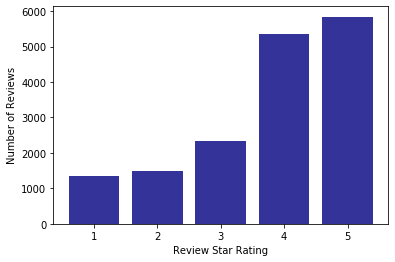

In [28]:
# star ratings 
# people more likely share their positive experience / postive experience occurs frequentlier

plt.bar([5,4,3,2,1], yelp['stars'].value_counts(), color='navy', alpha=0.8)
plt.xlabel('Review Star Rating')
plt.ylabel('Number of Reviews')
plt.show()

In [29]:
# How many 5 star reviews does Lo-Lo's Chicken & Waffles have?

filter = (yelp['business_name']=="Lo-Lo's Chicken & Waffles")&(yelp['stars']==5)
yelp[filter].shape[0]

20

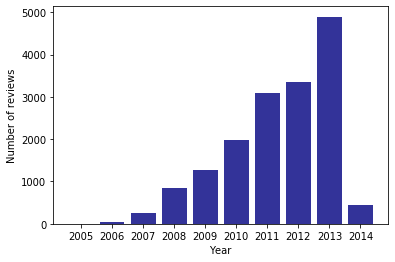

In [30]:
# number of reviews per year
rev_year = yelp.set_index(yelp['review_date']).review_id.resample('Y').count()
plt.bar(rev_year.index.year, rev_year, alpha=0.8, color='navy')
plt.xticks(range(rev_year.index.year.min(), rev_year.index.year.max()+1))
plt.ylabel('Number of reviews')
plt.xlabel('Year')
plt.show()

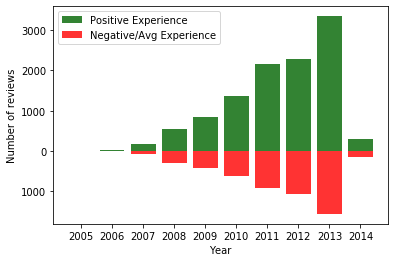

In [31]:

positive_experience = yelp[yelp['stars']>3]
negative_experience = yelp[yelp['stars']<=3]

pos_year = positive_experience.set_index(positive_experience['review_date']).review_id.resample('Y').count()
neg_year = negative_experience.set_index(negative_experience['review_date']).review_id.resample('Y').count()

plt.bar(pos_year.index.year, pos_year, alpha=0.8, color='darkgreen', label='Positive Experience')
plt.bar(neg_year.index.year, -neg_year, alpha=0.8, color='red', label='Negative/Avg Experience')

plt.xticks(range(rev_year.index.year.min(), rev_year.index.year.max()+1))
plt.ylabel('Number of reviews')
plt.xlabel('Year')
plt.yticks(ticks=[-1000, 0, 1000, 2000, 3000], labels=[1000, 0, 1000, 2000, 3000])
plt.legend()
plt.show()

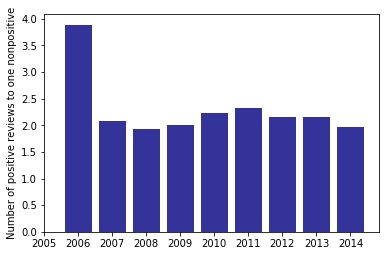

In [32]:
# relation of positive and nonpositive reviews

plt.bar(pos_year.index.year, pos_year/neg_year, alpha=0.8, color='navy')
plt.ylabel('Number of positive reviews to one nonpositive')
plt.xticks(range(rev_year.index.year.min(), rev_year.index.year.max()+1))
plt.show()

In [33]:
# add new variable that indicates positive or nonpositive experience

yelp['positive_experience'] = np.nan

yelp.loc[yelp['stars']>3, 'positive_experience'] = 1
yelp.loc[yelp['stars']<=3, 'positive_experience'] = 0

yelp['positive_experience'].value_counts(dropna=False)

1.0    11208
0.0     5158
NaN       14
Name: positive_experience, dtype: int64

### Groups of reviews

In [34]:
# reviews without any vote
no_votes = (yelp['cool']==0)&(yelp['funny']==0)&(yelp['useful']==0)

# all categories
all_votes = (yelp['cool']!=0)&(yelp['funny']!=0)&(yelp['useful']!=0)

# cool reviews
cool = (yelp['cool']!=0)&(yelp['funny']==0)&(yelp['useful']==0)

# funny reviews
funny = (yelp['cool']==0)&(yelp['funny']!=0)&(yelp['useful']==0)

# useful reviews
useful = (yelp['cool']==0)&(yelp['funny']==0)&(yelp['useful']!=0)

# cool and funny reviews
cool_funny = (yelp['cool']!=0)&(yelp['funny']!=0)&(yelp['useful']==0)

# cool and useful reviews
cool_useful = (yelp['cool']!=0)&(yelp['funny']==0)&(yelp['useful']!=0)

# funny and useful reviews
funny_useful = (yelp['cool']==0)&(yelp['funny']!=0)&(yelp['useful']!=0)

In [35]:
# check that all reviews are taken into account
# no_votes.sum()+all_votes.sum()+cool.sum()+funny.sum()+useful.sum()+cool_funny.sum()+cool_useful.sum()+funny_useful.sum()

In [36]:
# get a number of reviews per a group

groups = ['no_votes', 'all_votes', 'cool', 'funny', 'useful', 'cool_funny', 'cool_useful', 'funny_useful']

amounts = [no_votes.sum(), all_votes.sum(), cool.sum(), funny.sum(), useful.sum(),
             cool_funny.sum(), cool_useful.sum(), funny_useful.sum()]

review_groups = pd.Series(dict(zip(groups, amounts))).sort_values(ascending=False)

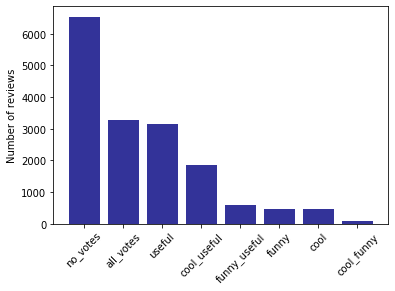

In [37]:
plt.bar(review_groups.index, review_groups, alpha=0.8, color='navy')
plt.xticks(rotation=45)
plt.ylabel('Number of reviews')
plt.show()

In [38]:
# amount of useful reviews

(yelp['useful'] != 0).sum()

8825

In [39]:
# create a new variable that indicates if review has any vote or not
yelp['vote_indicator'] = 1
yelp.loc[no_votes,'vote_indicator'] = 0

# aprx. 40% reviews has no votes <=> no information from users about reviews
yelp['vote_indicator'].value_counts()

1    9837
0    6543
Name: vote_indicator, dtype: int64

In [40]:
# how many observations with NAs

yelp.shape[0]-yelp.dropna().shape[0]

399

In [41]:
# delete NAs

yelp.dropna(inplace=True)

In [42]:
yelp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15981 entries, 0 to 16389
Data columns (total 11 columns):
business_name          15981 non-null object
review_id              15981 non-null object
user_id                15981 non-null object
stars                  15981 non-null float64
review_date            15981 non-null datetime64[ns]
review_text            15981 non-null object
funny                  15981 non-null int64
useful                 15981 non-null int64
cool                   15981 non-null int64
positive_experience    15981 non-null float64
vote_indicator         15981 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 1.5+ MB


### Cleaning Text of Reviews

In [43]:
yelp['review_clean'] = ''

# remove all punctuations
# string.punctuation
yelp['review_clean'] = yelp['review_text'].str.replace('[{}]'.format('!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~'), '')

# convert to lower case
yelp.loc[:,'review_clean'] = yelp['review_clean'].str.lower()

# remove digits
yelp.loc[:,'review_clean'] = yelp['review_clean'].str.replace('[0-9]', '')

# remove extra white spaces in text using tokenization and join
yelp.loc[:, 'review_clean'] = yelp['review_clean'].apply(word_tokenize)

# lemmatize
#lemmatizer = WordNetLemmatizer()
#yelp.loc[:, 'review_clean'] = yelp['review_clean'].apply(lambda S: [lemmatizer.lemmatize(s) for s in S])

# count a number of words in each review
word_counts = yelp['review_clean'].apply(len)   

yelp.loc[:, 'review_clean'] = yelp['review_clean'].apply(' '.join)

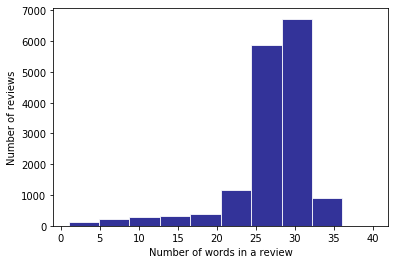

In [44]:
# word counts
plt.hist(word_counts, color='Navy', alpha=0.8, edgecolor='white')
plt.xlabel('Number of words in a review')
plt.ylabel('Number of reviews')
plt.show()

In [45]:
word_counts.max()

40

In [46]:
word_counts.min()

1

In [47]:
# one-word reviews
yelp.loc[word_counts==word_counts.min() ,'review_clean']

418               quick
817             amazing
2295             closed
2920                yum
4681         overpriced
5271            awesome
5548          expensive
6304               barf
7025             closed
9711            awesome
9934            amazing
10307           dislike
11469    bestcoffeeever
11550            awsome
12473               meh
13991             legit
14274           awesome
14363            closed
14595          friendly
14691         elephants
15601               hot
Name: review_clean, dtype: object

In [48]:
# the longest review
yelp.loc[word_counts==word_counts.max(),['review_clean']]

,review_clean
1788,d i s a p p o i n t e d i had long put off my ...


In [49]:
# Save cleaned data set
yelp.to_csv('./results/yelp_cleaned.csv', index_label=False)

In [50]:
# Bag-of-words

# Define a corpus
corpus = yelp['review_clean']

# Remove stopwords and single charachters
stop_words = stopwords.words(['english'])
stop_words.extend(list(string.ascii_lowercase))
stop_words.extend(["i've", "we've", "i'm"])

Bag-of-words model requires to specify the n-grams range. The n-grams represent the groups of n words, corresponding to the sequence of n consistently occuring words in a document. This sequence of n words is treated as pseudo-term.

In [51]:
vectorizer = CountVectorizer(
                             stop_words=stop_words, 
                             ngram_range = (1,1), 
                             binary=False)

freq = vectorizer.fit_transform(corpus).toarray()
terms = vectorizer.get_feature_names()

# Document-term matrix
dtm = pd.DataFrame(freq, columns = terms, index=yelp.index)

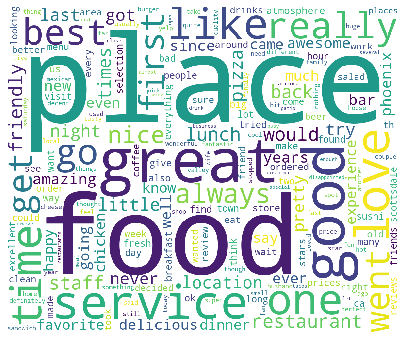

In [52]:
# Words cloud
term_total_freq = dtm.sum(axis=0).sort_values(ascending=False)

wordcloud = WordCloud( 
                       background_color='white',
                       width=1200,
                       height=1000,
                       random_state=50).generate_from_frequencies(term_total_freq)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud)
plt.axis('off')

plt.savefig('./figs/yelp_review_wordcloud.png')
plt.show()

In [53]:
# difference between top500 words in positive and nonpositive reviews

filter = yelp['positive_experience']==1

set_positive = dtm[filter].sum(axis=0).sort_values(ascending=False).head(500).index
set_negative = dtm[~filter].sum(axis=0).sort_values(ascending=False).head(500).index

len(set_positive.difference(set_negative))

86

In [54]:
# difference in % between top500 words in positive and nonpositive reviews
'{}%'.format(len(set_positive.difference(set_negative))/5)

'17.2%'

In [55]:
# difference between words in positive and nonpositive reviews that occurs in more than in 100 reviews

filter = yelp['positive_experience']==1

positive = dtm[filter].sum(axis=0).sort_values(ascending=False)
negative = dtm[~filter].sum(axis=0).sort_values(ascending=False)

set_positive = positive[positive>100].index
set_negative = negative[negative>100].index

len(set_positive.difference(set_negative))

152

In [56]:
# difference in % between words in positive and nonpositive reviews that occurs in more than in 100 reviews

'{}%'.format( round(len(set_positive.difference(set_negative))/len(dtm)*100, 2))

'0.95%'